In [1]:
import pandas as pd
import numpy as np 
import matplotlib.pyplot as plt
import glob
import corner, emcee, tqdm
from tweezepy import AV, PSD, MLE
import os

In [52]:
## Opens the folder and stores the data within the files into a Pandas Dataframe
# Requests the folder location from the user
folderPath = input("Type the path to the folder location:")

# Checks to see if the path is correct and returns an error if it is not
if os.path.exists(folderPath):
    print("Using: " + folderPath)
else: 
    raise FileNotFoundError('No such file or directory.')

# Requests the number of reference and experimental beads from the user to create list of the bead names
numRef = int(input("Number of reference beads:"))
numExp = int(input("Number of experimental beads:"))

# Initialization of that list
nameList = ["inf","linearMotor","rotationalMotor"]

# Adds names to the list depending on how many beads were given
for i in range(numRef):
    nameList = nameList + ["xRefBead"+str(i+1), "yRefBead"+str(i+1), "zRefBead"+str(i+1)]
for i in range(numExp): 
    nameList = nameList + ["xExpBead"+str(i+1), "yExpBead"+str(i+1), "zExpBead"+str(i+1)]

# Stores the file names into a list
files = glob.glob(folderPath + '/*.txt')

# Turns the data into a table, then concatenates this table into a Pandas dataframe 
dataTable = [pd.read_table(files[i], names=nameList) for i in range(len(files))]
dataFrame = pd.concat([pd.DataFrame(dataTable[i], columns=nameList) for i in range(len(files))],
          ignore_index=True)

# Uses the conversion values to convert the pixels to nanometers. Also converts the z-axis to nm from um
xConv = 64.6
yConv = 64.7
for column in dataFrame.columns:
    if column[0] == 'x': dataFrame[column] = dataFrame[column]*xConv
    if column[0] == 'y': dataFrame[column] = dataFrame[column]*yConv
    if column[0] == 'z': dataFrame[column] = dataFrame[column]*1000

# Requests the fps and then creates a time series from this
fps = int(input("Frames per second:"))
timeVector = pd.Series(range(len(dataFrame)))/fps

FileNotFoundError: No such file or directory.

In [5]:
lowForce = []
highForce = []
mediumForce = []

for index in dataFrame.itertuples():
    if dataFrame['linearMotor'][index[0]] <= 15: lowForce = lowForce + [index[0]]
    if 15 < dataFrame['linearMotor'][index[0]]  <= 28: mediumForce = mediumForce + [index[0]]
    if 30 < dataFrame['linearMotor'][index[0]] : highForce = highForce + [index[0]]
    if index[0] % 50000 == 0: print("Finding the low, medium, and high force points")

Finding the low, medium, and high force points
Finding the low, medium, and high force points
Finding the low, medium, and high force points
Finding the low, medium, and high force points
Finding the low, medium, and high force points


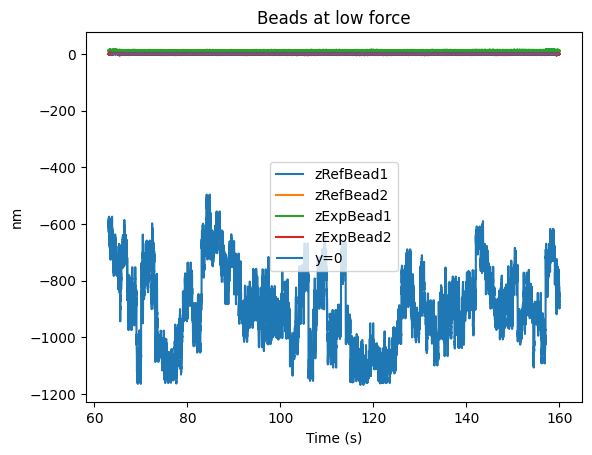

In [6]:
# Goes through and plots (the different beads) - refbead1 so the user can determine which beads are tethers and which are reference beads.
for column in dataFrame.columns:
    if column[0] == 'z': a = plt.plot(timeVector[min(lowForce):max(lowForce)], dataFrame[column][min(lowForce):max(lowForce)] - dataFrame['zRefBead2'][min(lowForce):max(lowForce)], 
                                      label=column)
# Labelling of the plot
plt.title("Beads at low force"); plt.xlabel("Time (s)"); plt.ylabel("nm"); plt.hlines(0, timeVector[min(lowForce)], timeVector[max(lowForce)], label="y=0"); plt.legend(loc='best');

For RefBead1:
	The low force x-variance is: 5532.6283756205885
	The low force y-variance is: 39278.77953750525
	The low force z-variance is: 19403.95842839193


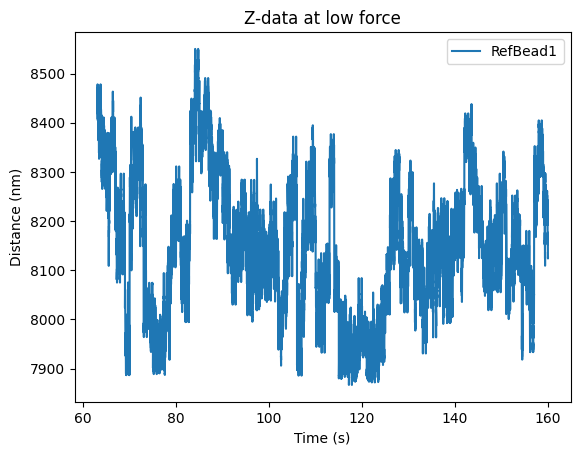

In [7]:
# Asks the user how many tethered beads there are
numGoodBeads = int(input("Number of beads you want to use:"))

# Asks the user to list the beads they want to analyze and checks if the user properly did that.
goodBeads = []
for i in range(numGoodBeads):
    goodBead = input("Which beads (one at a time):") # User input

    if goodBead in dataFrame.columns: # Checks if the beads are good
        goodBeads = goodBeads + [goodBead[1:]]
    else: print("'" + i + "'" + " is not a valid bead and will not be considered in analysis.")

# Goes through the good beads and calculates the variance in the different axes
for i in goodBeads:
    print("For " + i + ":")
    print('\tThe low force x-variance is:', np.var(dataFrame["x" + i][min(lowForce):max(lowForce)]),)
    print('\tThe low force y-variance is:', np.var(dataFrame["y" + i][min(lowForce):max(lowForce)]))
    print('\tThe low force z-variance is:', np.var(dataFrame["z" + i][min(lowForce):max(lowForce)]))
    plt.plot (timeVector[min(lowForce):max(lowForce)], dataFrame["z" + i][min(lowForce):max(lowForce)], # plots the good beads at low force
              label=i)
# Labelling of the plot
plt.title('Z-data at low force'); plt.xlabel('Time (s)'); plt.ylabel('Distance (nm)'); plt.legend(loc='best');

# Subtracts the reference bead from the tethered beads 
for i in goodBeads:
    dataFrame["x" + i] = dataFrame["x" + i] - dataFrame["xExpBead2"]
    dataFrame["y" + i] = dataFrame["y" + i] - dataFrame["yExpBead2"]
    dataFrame["z" + i] = dataFrame["z" + i] - dataFrame["zExpBead2"]

The glass position is:  -1161.6473333333333


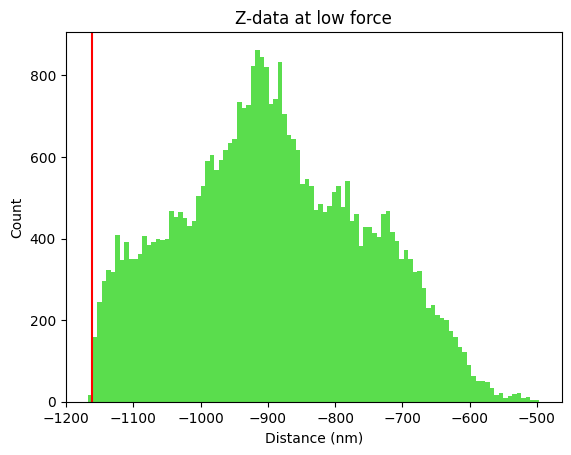

In [40]:
## Now we try and fiund the glass position
beadDiameter = 2800

# This sorts the data so that a percentage of it can be used to average for the glass position
sortedZdata = np.sort(dataFrame["z" + goodBeads[0]][min(lowForce):max(lowForce)])

# Averages the sorted array and then subtracts off the beads diameter to get the final bead position
glassPosition = np.mean(np.sort(dataFrame["z" + goodBeads[0]][min(lowForce):max(lowForce)])[0:30])# - beadDiameter/2
print('The glass position is: ', glassPosition)

# Calculates the extension
tetherExtension = dataFrame["z" + goodBeads[0]] - glassPosition

# Plots a histogram of the tethered beads
for i in goodBeads:
    plt.hist(dataFrame["z" + i][min(lowForce):max(lowForce)], bins = 100, color='#5ADD4D')
    plt.axvline(glassPosition, color="red", label="glass position")
    # plt.xlim(min(dataFrame["z" + i][min(lowForce):max(lowForce)]), max(dataFrame["z" + i][min(lowForce):max(lowForce)])) # limits out any outliers
# Labelling of the plot
plt.title('Z-data at low force'); plt.ylabel('Count'); plt.xlabel('Distance (nm)');

Low force using AV:  0.24968361330058209
Low force using PSD:  0.18043813976484083
Low force using F = KbT*L/<x>:  0.20087127711385755


Text(0.5, 1.0, 'Low Force')

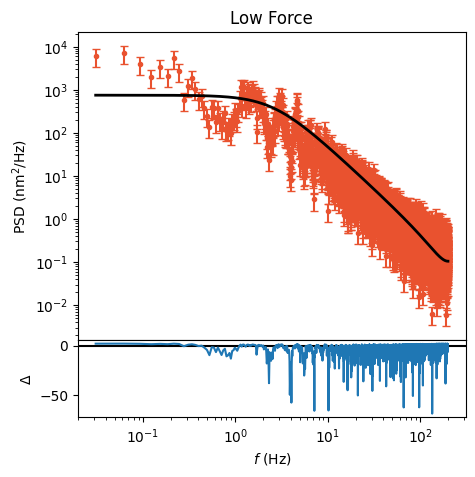

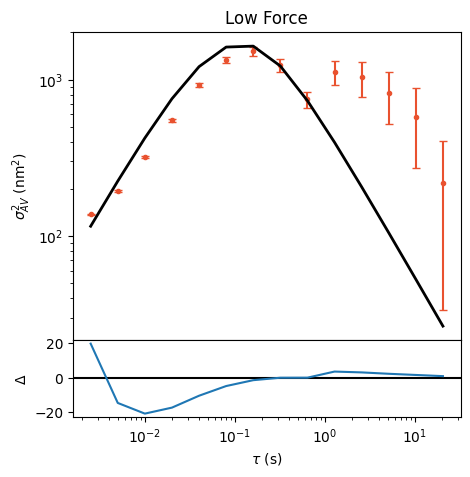

In [26]:

psd = PSD(dataFrame["xRefBead1"][min(lowForce):max(lowForce)], fps, bins=5)
psd.mlefit(viscosity=1e-9, radius=beadDiameter/2)
av = AV(dataFrame["xRefBead1"][min(lowForce):max(lowForce)], fps)
av.mlefit(viscosity=1e-9, radius=beadDiameter/2)

# Calculation and printing of the force
force = av.results['k']*np.mean(tetherExtension[min(lowForce):max(lowForce)])
print('Low force using AV: ', force)
force = psd.results['k']*np.mean(tetherExtension[min(lowForce):max(lowForce)])
print('Low force using PSD: ', force)
force = 4.1*np.mean(tetherExtension[min(lowForce):max(lowForce)])/np.var(dataFrame["xRefBead1"][min(lowForce):max(lowForce)])
print('Low force using F = KbT*L/<x>: ', force)

# Printing of PSD and AV Plots
fig, ax = psd.plot(data_color='#E9522F') #PSD
ax[0].set_title('Low Force'); ax[0].set_xlabel('f (Hz)');

fig, ax = av.plot(data_color='#E9522F') #AV
ax[0].set_title('Low Force')

High force using AV:  10.873048236071554
High force using PSD:  10.41018886518409
High force using F = KbT*L/<x>:  14.970125701386891


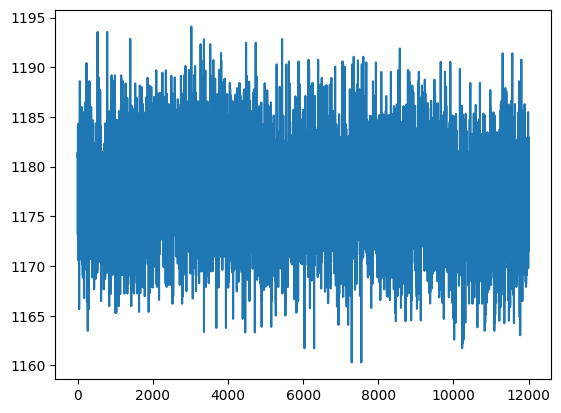

In [49]:
# plt.plot(dataFrame["linearMotor"][000:65000]);
plt.plot(tetherExtension[000:12000]);




psd = PSD(dataFrame["xRefBead1"][000:12000], fps, bins=5)
psd.mlefit(viscosity=1e-9, radius=beadDiameter/2)
av = AV(dataFrame["xRefBead1"][000:12000], fps)
av.mlefit(viscosity=1e-9, radius=beadDiameter/2)

# Calculation and printing of the force
force = av.results['k']*np.mean(tetherExtension[000:12000])
print('High force using AV: ', force)
force = psd.results['k']*np.mean(tetherExtension[000:12000])
print('High force using PSD: ', force)
force = 4.1*np.mean(tetherExtension[000:12000])/np.var(dataFrame["xRefBead1"][000:12000])
print('High force using F = KbT*L/<x>: ', force)





In [50]:
plt.plot(dataFrame["zMotor"])

KeyError: 'zMotor'